In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_01_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 256)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fc5386b0060> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(26008)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

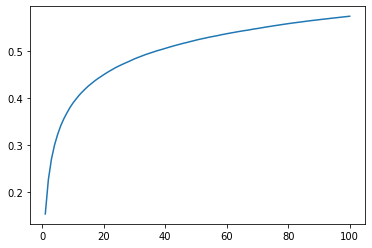

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.1536, 0.2267, 0.2703, 0.3003, 0.3226, 0.3412, 0.3559, 0.3684, 0.3801,
        0.3899, 0.3983, 0.4064, 0.4134, 0.4199, 0.4260, 0.4314, 0.4367, 0.4415,
        0.4458, 0.4502, 0.4544, 0.4584, 0.4621, 0.4658, 0.4690, 0.4721, 0.4751,
        0.4779, 0.4809, 0.4840, 0.4866, 0.4891, 0.4916, 0.4940, 0.4961, 0.4983,
        0.5005, 0.5025, 0.5043, 0.5063, 0.5083, 0.5102, 0.5121, 0.5139, 0.5155,
        0.5173, 0.5188, 0.5206, 0.5222, 0.5239, 0.5255, 0.5269, 0.5282, 0.5297,
        0.5310, 0.5323, 0.5335, 0.5350, 0.5363, 0.5375, 0.5388, 0.5399, 0.5411,
        0.5423, 0.5434, 0.5444, 0.5453, 0.5466, 0.5478, 0.5487, 0.5498, 0.5509,
        0.5521, 0.5530, 0.5541, 0.5551, 0.5561, 0.5571, 0.5581, 0.5590, 0.5600,
        0.5608, 0.5616, 0.5625, 0.5634, 0.5642, 0.5651, 0.5659, 0.5666, 0.5674,
        0.5682, 0.5690, 0.5696, 0.5705, 0.5712, 0.5719, 0.5727, 0.5734, 0.5741,
        0.5748])

In [18]:
percentages.max()

tensor(0.5748)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.61836037, 0.59970887, 0.58720664, 0.57749656, 0.57024855,
       0.56372471, 0.55794706, 0.55292808, 0.54860516, 0.54452502,
       0.54096285, 0.53780296, 0.53495932, 0.53213216, 0.52950363,
       0.52710844, 0.52491723, 0.52285598, 0.52093431, 0.51904005,
       0.51744909, 0.51591445, 0.51443161, 0.51295964, 0.51149419,
       0.51022254, 0.5089716 , 0.50774232, 0.50656991, 0.50541642,
       0.50435088, 0.50331428, 0.50231957, 0.50134864, 0.50035963,
       0.49944787, 0.49853416, 0.49764896, 0.49685519, 0.49599526,
       0.49524669, 0.49445673, 0.49372397, 0.49299767, 0.49230287,
       0.49157896, 0.49086526, 0.49018289, 0.48948849, 0.48884371,
       0.48822271, 0.48760311, 0.48699107, 0.4863667 , 0.48578437,
       0.48518529, 0.48461438, 0.48407894, 0.48353602, 0.48301022,
       0.48246226, 0.48193959, 0.48145077, 0.48096827, 0.48045873,
       0.47996786, 0.47947947, 0.47900815, 0.47854911, 0.4780794 ,
       0.4776418 , 0.47719159, 0.47672233, 0.47628099, 0.47585

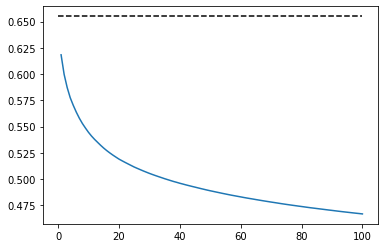

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fc4605c5870> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(27271)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [37]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [38]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

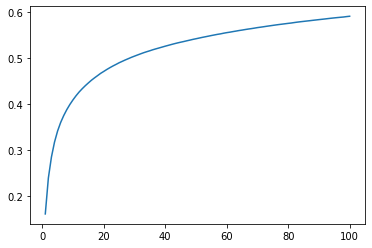

In [39]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [40]:
percentages

tensor([0.1610, 0.2393, 0.2850, 0.3175, 0.3416, 0.3603, 0.3753, 0.3883, 0.3995,
        0.4094, 0.4184, 0.4266, 0.4337, 0.4403, 0.4463, 0.4522, 0.4574, 0.4623,
        0.4672, 0.4714, 0.4757, 0.4796, 0.4833, 0.4867, 0.4903, 0.4933, 0.4964,
        0.4992, 0.5021, 0.5047, 0.5073, 0.5098, 0.5122, 0.5144, 0.5165, 0.5187,
        0.5207, 0.5226, 0.5245, 0.5264, 0.5282, 0.5301, 0.5319, 0.5335, 0.5351,
        0.5365, 0.5381, 0.5396, 0.5412, 0.5426, 0.5441, 0.5455, 0.5469, 0.5482,
        0.5496, 0.5509, 0.5522, 0.5533, 0.5547, 0.5559, 0.5569, 0.5582, 0.5593,
        0.5605, 0.5615, 0.5627, 0.5637, 0.5647, 0.5657, 0.5669, 0.5678, 0.5688,
        0.5698, 0.5708, 0.5717, 0.5727, 0.5736, 0.5744, 0.5753, 0.5761, 0.5769,
        0.5779, 0.5789, 0.5797, 0.5804, 0.5812, 0.5820, 0.5828, 0.5835, 0.5843,
        0.5850, 0.5858, 0.5866, 0.5874, 0.5881, 0.5888, 0.5894, 0.5900, 0.5909,
        0.5917])

### Percentage of same class neighbors by neighborhood size

In [41]:
ind_labels = label_transform(indices)

In [42]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [43]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [44]:
perc_same_class = n_same_class / n_total

In [45]:
perc_same_class

array([0.63091477, 0.6128597 , 0.59937523, 0.58866472, 0.58020349,
       0.57317299, 0.56709164, 0.56172531, 0.55702332, 0.55283537,
       0.54914421, 0.54562633, 0.54240438, 0.53954569, 0.53686266,
       0.53436295, 0.53202394, 0.52989724, 0.52777903, 0.52589301,
       0.52401564, 0.5223127 , 0.52060123, 0.51907002, 0.51761053,
       0.51620993, 0.51487984, 0.51359856, 0.5123914 , 0.51120468,
       0.51001946, 0.50893767, 0.50785845, 0.5068401 , 0.50579019,
       0.50476269, 0.50381163, 0.50284598, 0.50191244, 0.50103842,
       0.50016758, 0.49935929, 0.49856415, 0.4977771 , 0.4969879 ,
       0.49624521, 0.49551464, 0.49479988, 0.49409947, 0.4934162 ,
       0.49274017, 0.49209785, 0.49144569, 0.49081789, 0.49019886,
       0.48956007, 0.48897468, 0.48841354, 0.4878462 , 0.48727464,
       0.48671505, 0.48616713, 0.48562179, 0.48509137, 0.48458127,
       0.4840699 , 0.48355369, 0.48306778, 0.48259775, 0.48211196,
       0.48164401, 0.48117685, 0.48070023, 0.4802357 , 0.47978

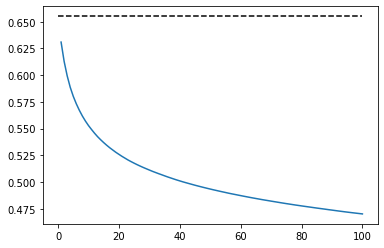

In [46]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [53]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [54]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [55]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fc4146b0c60> >

In [56]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [57]:
distances, indices = index_ip.search(embeddings, 2)

In [58]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(1828)

In [59]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [60]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

540.2899254048825

In [61]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [62]:
indices

array([[ 60027,     57, 132536, ...,  66843, 158860,  73463],
       [ 60027,     57,  44847, ...,  18277, 125796,  95651],
       [ 60027, 100836,     57, ...,  73463,  14905,  99328],
       ...,
       [ 60027, 112851, 135274, ...,  62101, 124757,  98283],
       [    57,  60027,  54038, ...,  36140, 135058, 148390],
       [ 60027, 135274,     57, ..., 156182, 167942, 127021]])

In [63]:
sum(embeddings[0] * embeddings[411])

1079.579850809765

In [64]:
distances

array([[ 6542.8403,  6406.2695,  5864.424 , ...,  3706.21  ,  3705.513 ,
         3698.5598],
       [18460.012 , 18284.838 , 18121.834 , ..., 11887.345 , 11868.359 ,
        11862.066 ],
       [11186.76  ,  9660.958 ,  9573.162 , ...,  6265.85  ,  6265.116 ,
         6260.9985],
       ...,
       [ 9564.825 ,  8083.418 ,  7595.2524, ...,  4935.0454,  4925.438 ,
         4921.9785],
       [ 8864.952 ,  8412.216 ,  8086.42  , ...,  5327.0947,  5307.949 ,
         5277.1045],
       [17818.818 , 17266.387 , 16244.619 , ..., 10841.764 , 10841.187 ,
        10818.635 ]], dtype=float32)

In [65]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [66]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

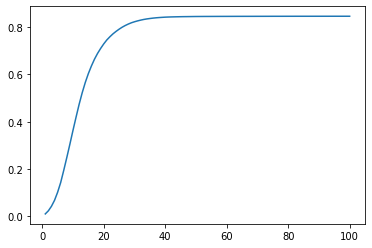

In [67]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [68]:
percentages

tensor([0.0108, 0.0239, 0.0429, 0.0681, 0.1019, 0.1430, 0.1946, 0.2489, 0.3051,
        0.3630, 0.4188, 0.4729, 0.5218, 0.5652, 0.6027, 0.6350, 0.6637, 0.6880,
        0.7090, 0.7280, 0.7447, 0.7582, 0.7704, 0.7808, 0.7902, 0.7986, 0.8058,
        0.8120, 0.8173, 0.8216, 0.8253, 0.8285, 0.8313, 0.8335, 0.8353, 0.8370,
        0.8383, 0.8394, 0.8403, 0.8411, 0.8416, 0.8420, 0.8424, 0.8427, 0.8430,
        0.8432, 0.8433, 0.8435, 0.8437, 0.8438, 0.8439, 0.8440, 0.8441, 0.8441,
        0.8441, 0.8442, 0.8442, 0.8443, 0.8443, 0.8443, 0.8444, 0.8444, 0.8444,
        0.8445, 0.8445, 0.8445, 0.8445, 0.8445, 0.8446, 0.8446, 0.8446, 0.8446,
        0.8446, 0.8447, 0.8447, 0.8447, 0.8447, 0.8447, 0.8447, 0.8448, 0.8448,
        0.8448, 0.8448, 0.8448, 0.8448, 0.8448, 0.8448, 0.8448, 0.8448, 0.8449,
        0.8449, 0.8449, 0.8449, 0.8449, 0.8449, 0.8449, 0.8449, 0.8449, 0.8449,
        0.8449])

### Percentage of same class neighbors by neighborhood size

In [69]:
ind_labels = label_transform(indices)

In [70]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [71]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [72]:
perc_same_class = n_same_class / n_total

In [73]:
perc_same_class

array([0.01205837, 0.01534164, 0.01947723, 0.02402963, 0.02891882,
       0.03396952, 0.03985487, 0.04514506, 0.04977209, 0.05390362,
       0.05745306, 0.06047932, 0.06286331, 0.06457393, 0.06584585,
       0.06667016, 0.06721305, 0.06743119, 0.06741876, 0.06728976,
       0.06705748, 0.06665949, 0.06620625, 0.06570319, 0.06517518,
       0.06463782, 0.06407136, 0.06351205, 0.06300679, 0.06250568,
       0.06199443, 0.06150627, 0.06106183, 0.060622  , 0.06020208,
       0.05982647, 0.05943973, 0.05911748, 0.05880297, 0.05849947,
       0.05826103, 0.05800484, 0.05778296, 0.05756109, 0.05735053,
       0.05716363, 0.05699863, 0.05681762, 0.05666606, 0.05650343,
       0.05635841, 0.05624452, 0.05612757, 0.05600315, 0.05589516,
       0.05578292, 0.05568507, 0.0555795 , 0.05549303, 0.05541613,
       0.05533246, 0.05527367, 0.05520092, 0.05513523, 0.05508102,
       0.05504178, 0.05498449, 0.05493627, 0.05487662, 0.05482828,
       0.05478688, 0.05474458, 0.05472018, 0.05468439, 0.05466

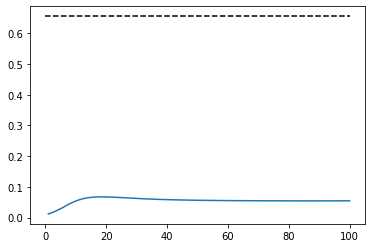

In [74]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [47]:
pca = PCA(n_components=2)

In [48]:
pca.fit(embeddings)

PCA(n_components=2)

In [49]:
emb_2d = pca.transform(embeddings)

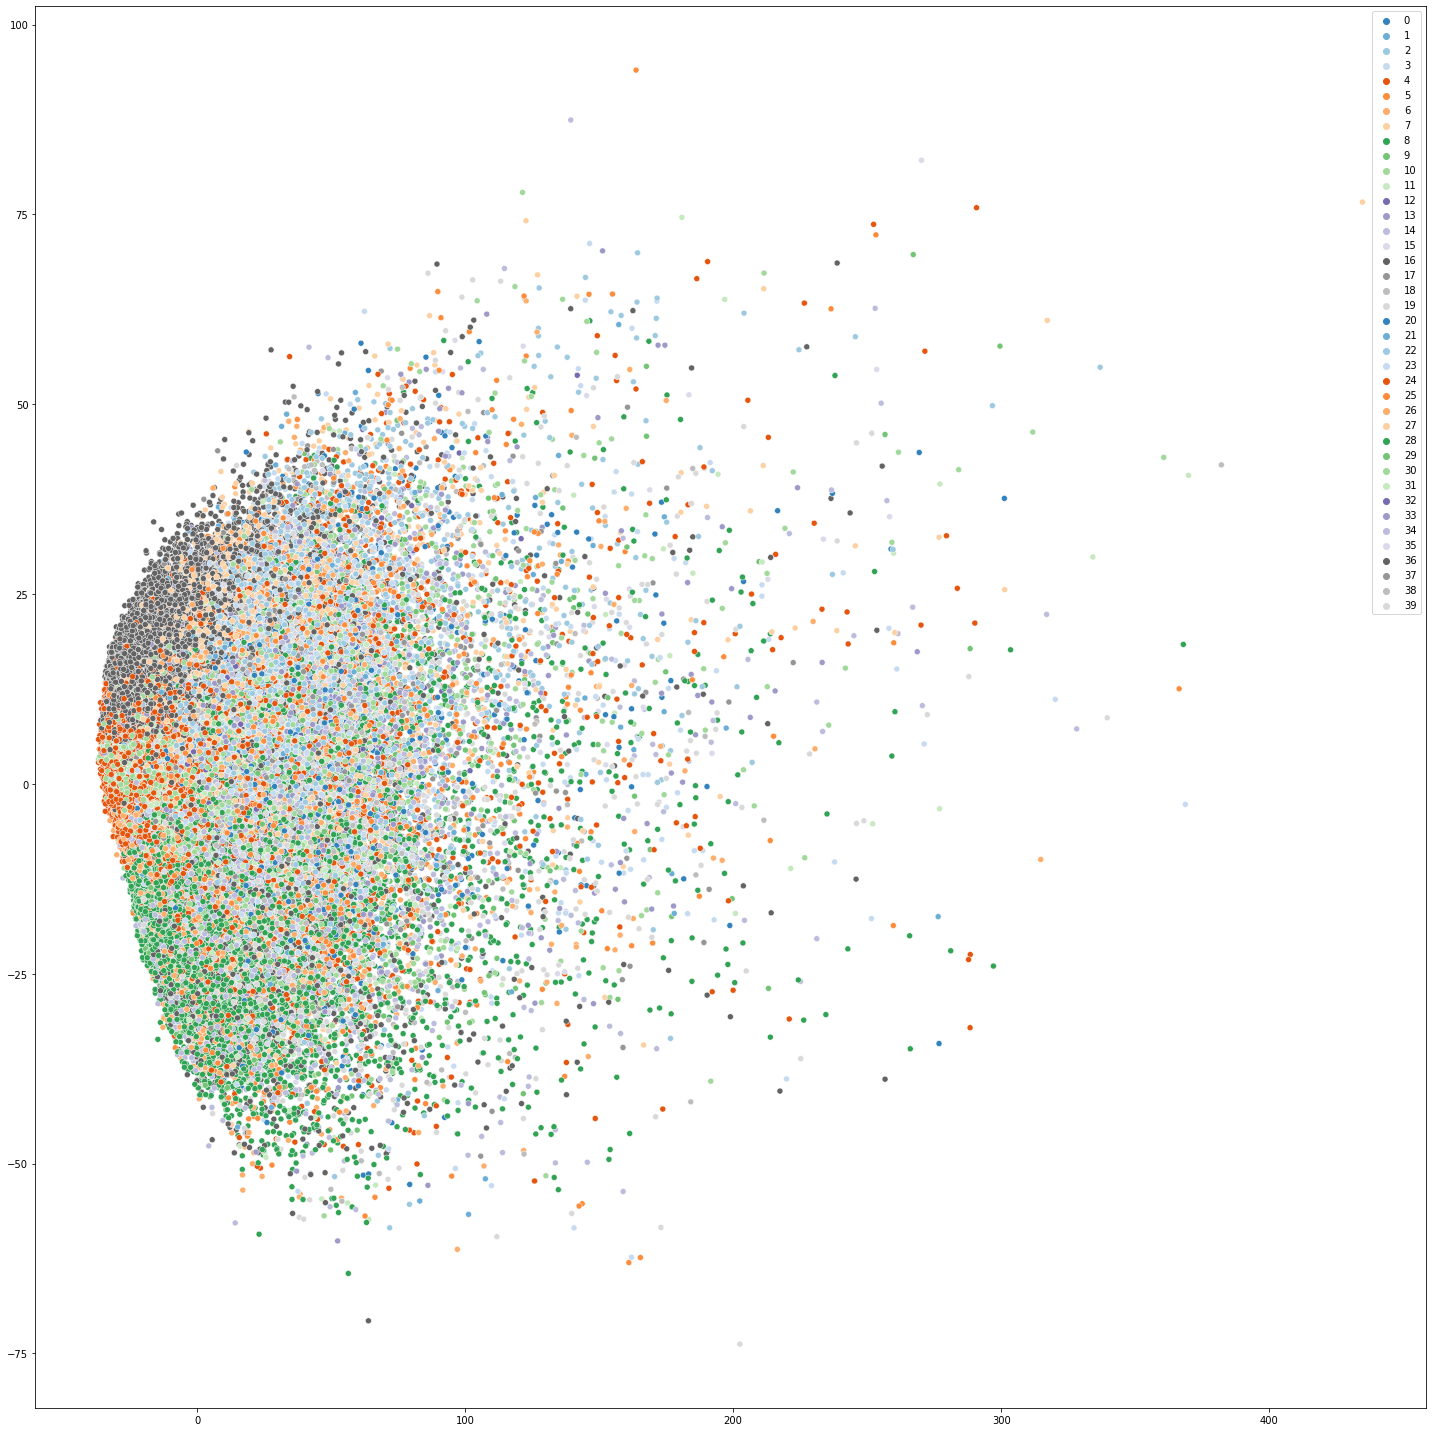

In [50]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [51]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

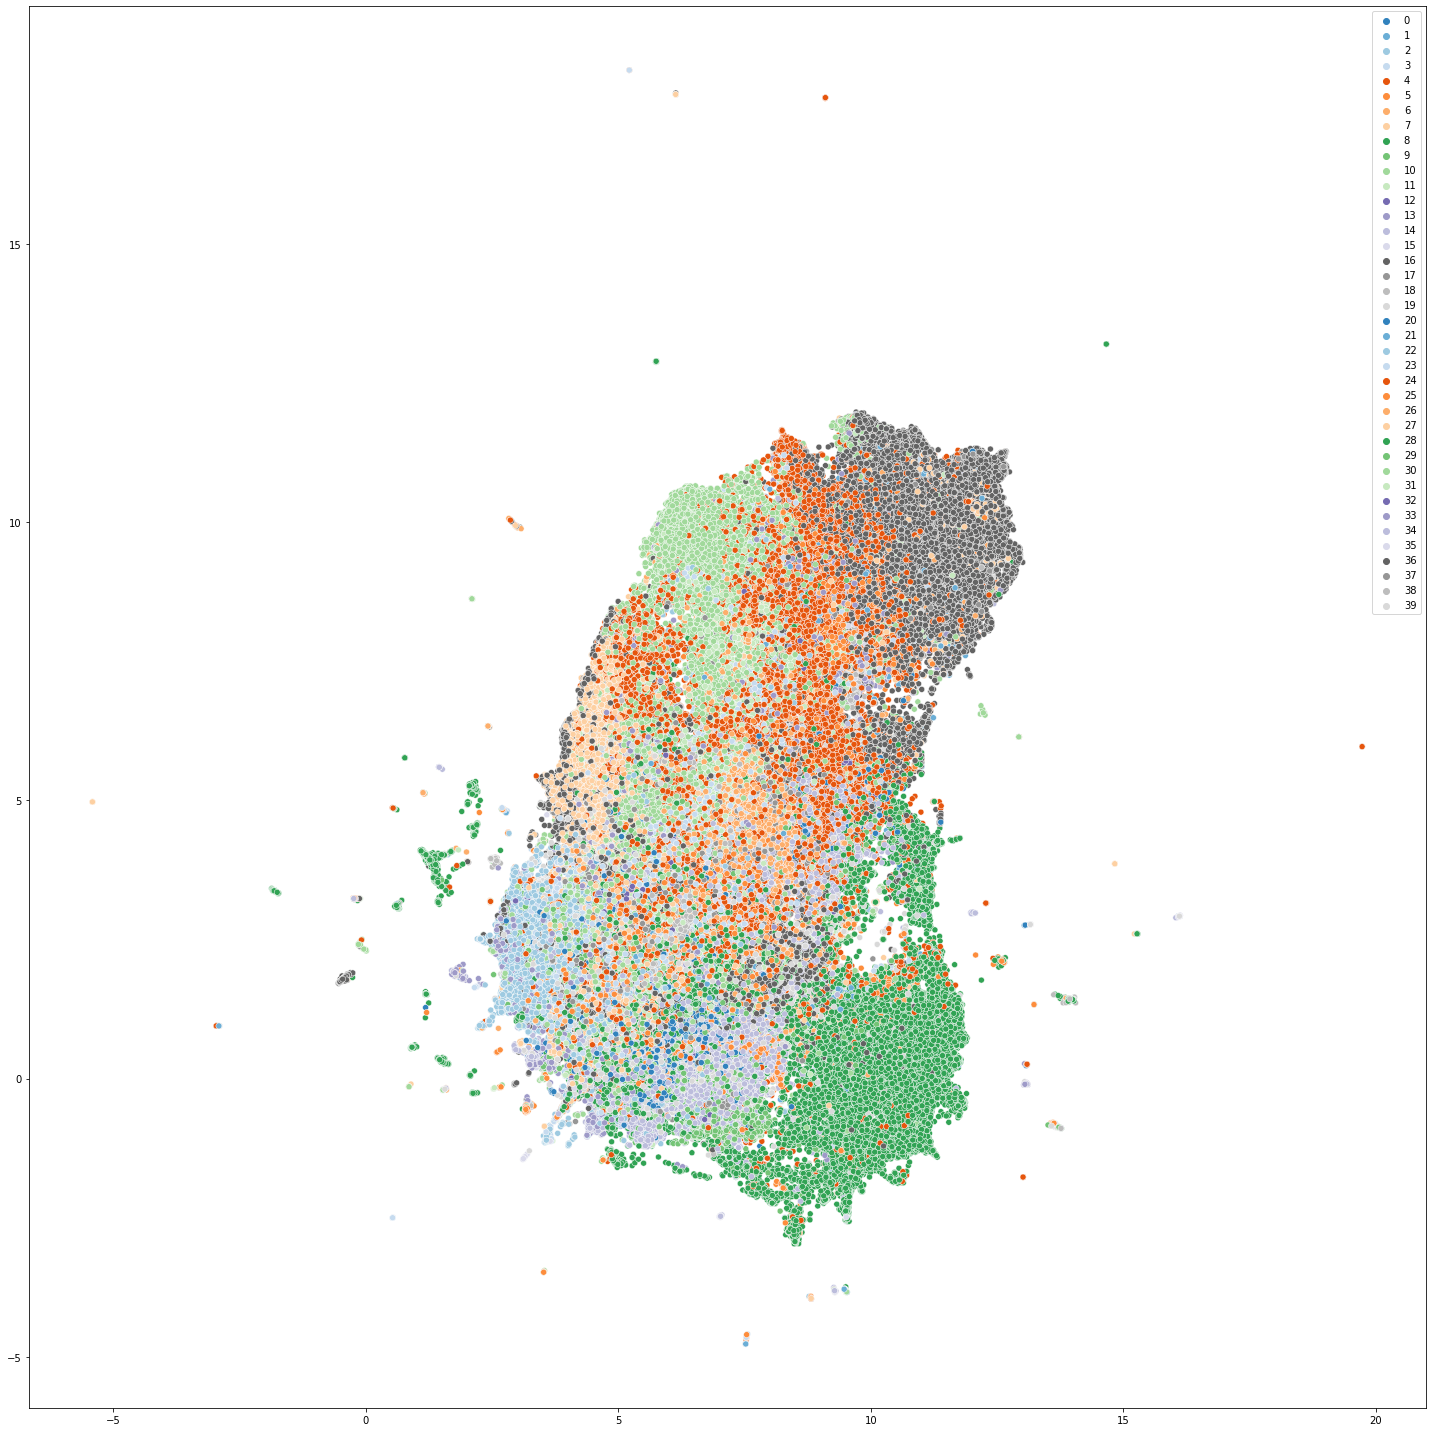

In [52]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [77]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

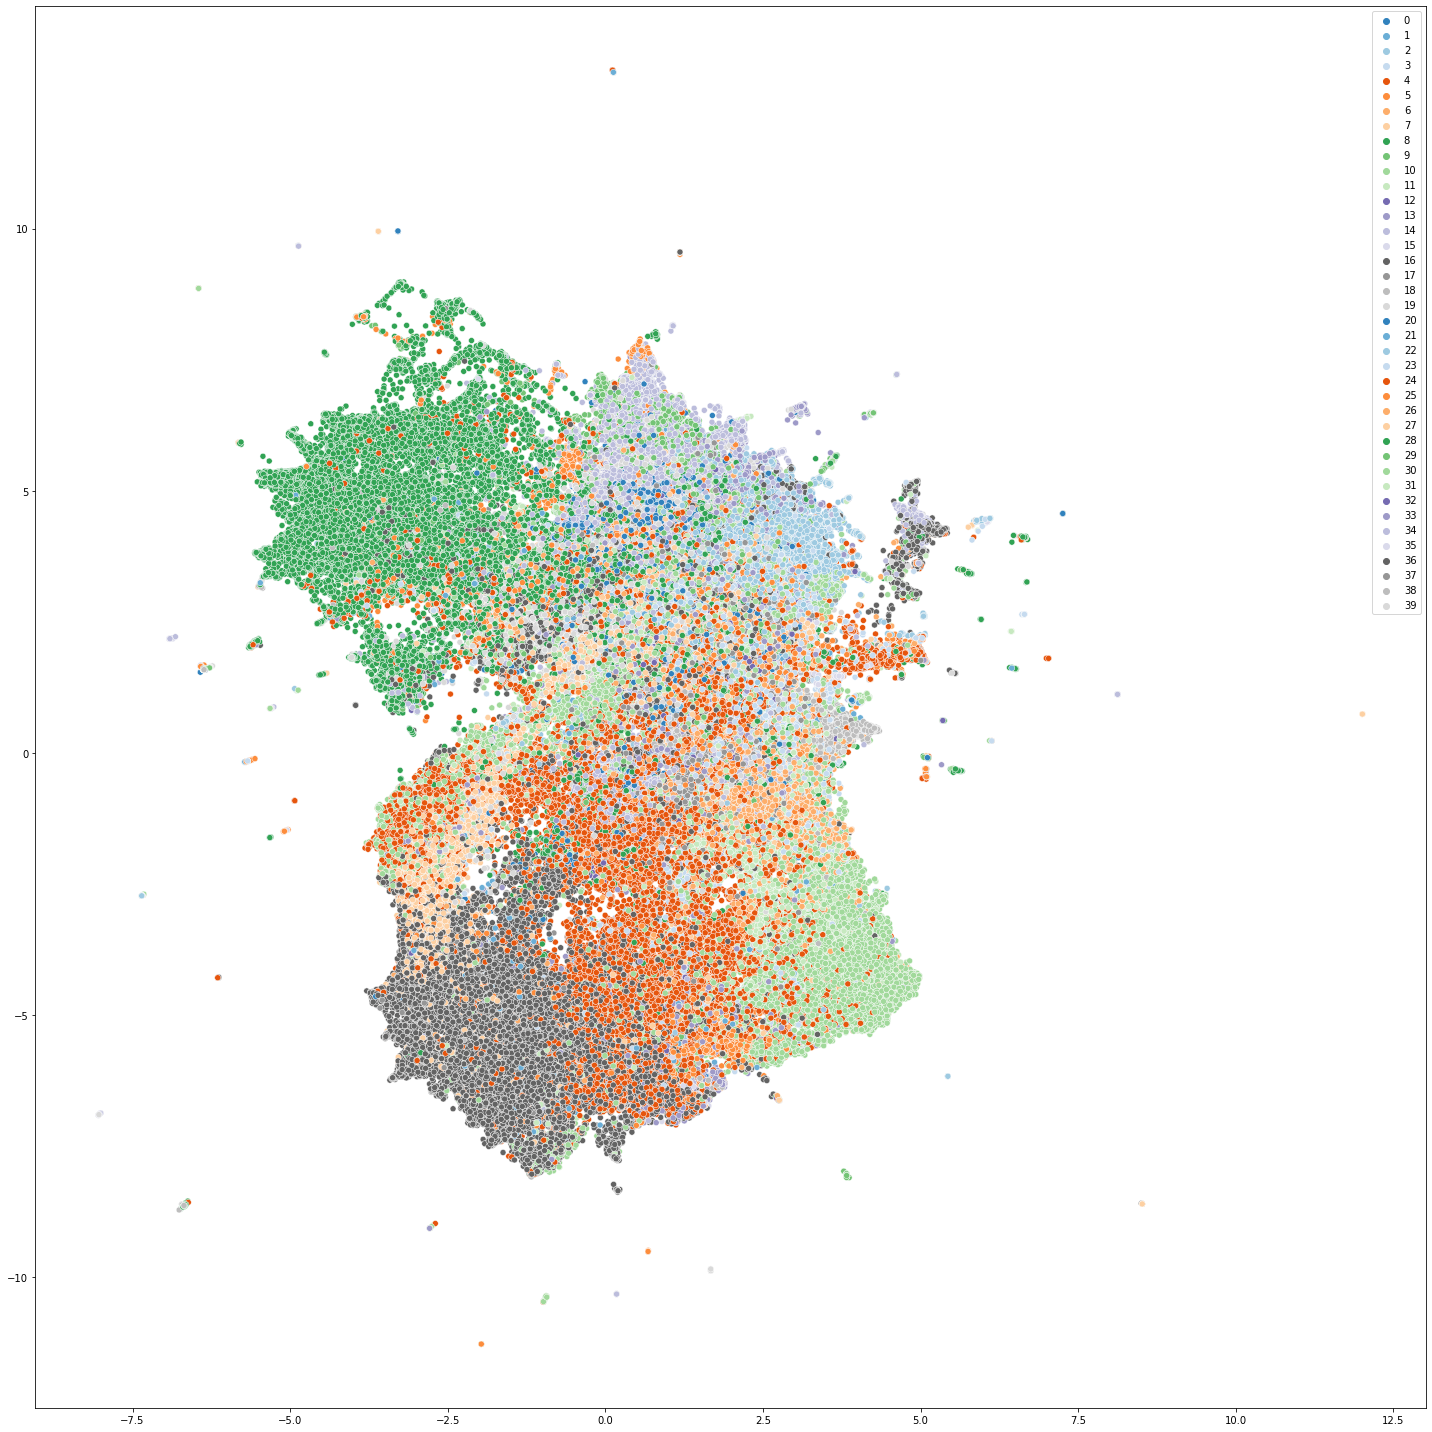

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()